# Model Monitoring for Cardiac Image Segmentation

In [1]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-b5656686-13d3-3057-120e-327ecf3db15f)


In [56]:
import random
import numpy as np
import torch

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Install requirements

#### batchgenerators

In [2]:
!pip install --upgrade batchgenerators

     |████████████████████████████████| 57 kB 3.0 MB/s 
     |████████████████████████████████| 96 kB 5.5 MB/s 
  Created wheel for batchgenerators: filename=batchgenerators-0.23-py3-none-any.whl size=84780 sha256=9dfd473201f9bec81ac232e174eeec4a2854407085e258b749f1702010831064
  Stored in directory: /root/.cache/pip/wheels/81/3d/a2/9a602ce56458c684d2962ec89eddd6bc06b00687735e2dd11a
Successfully built batchgenerators


#### medpy

In [3]:
!pip install medpy

     |████████████████████████████████| 151 kB 8.2 MB/s 
     |████████████████████████████████| 48.4 MB 9.2 kB/s 
  Created wheel for medpy: filename=MedPy-0.4.0-cp37-cp37m-linux_x86_64.whl size=754474 sha256=ccbdaa8fd586abaf14346b3c9e1d6a3ebeee33d8d0ea56f3205874da25b0ec93
  Stored in directory: /root/.cache/pip/wheels/b0/57/3a/da1183f22a6afb42e11138daa6a759de233fd977a984333602
Successfully built medpy


#### nibabel

In [4]:
!pip install nibabel

## Import data

In [5]:
!git clone https://github.com/manigalati/quality_control_CMR

Cloning into 'quality_control_CMR'...
remote: Enumerating objects: 103, done.
remote: Counting objects: 100% (103/103), done.
remote: Compressing objects: 100% (101/101), done.
remote: Total 103 (delta 57), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (103/103), 268.67 KiB | 4.80 MiB/s, done.
Resolving deltas: 100% (57/57), done.


In [6]:
%cd /content/quality_control_CMR

/content/quality_control_CMR


In [7]:
!mkdir data
#training set
!python gdrivedl.py https://drive.google.com/open?id=1bxRj0zf-iMooYA4jUZS_zS4VD9NLYxE4 data/
#testing set
!python gdrivedl.py https://drive.google.com/open?id=1L84oEmgc2Nd10bCBlaM7vkbl7nhrYC9I data/
#predictions
!python gdrivedl.py https://drive.google.com/open?id=1P2kNGllKUKmumaCM2IsqgIgRPAKEXa59 data/
#measures
!python gdrivedl.py https://drive.google.com/open?id=1ss-qGFEocJT-h3JAebcDjeWBQXcxPs0T data/

data/training.zip
[==================================================] 1554.02MB/1554.02MB
data/testing.zip
[==================================================] 762.27MB/762.27MB
data/predictions.zip
[==================================================] 3.75MB/3.75MB
data/measures.zip
[==================================================] 0.05MB/0.05MB


In [8]:
!unzip -q data/training.zip -d data/

In [9]:
!unzip -q data/testing.zip -d data/ 
!mv data/testing/testing data/tmp && rm -r data/testing && mv data/tmp data/testing

In [10]:
!unzip -q data/predictions.zip -d data/

In [11]:
!unzip -q data/measures.zip -d data/

## Data preparation

In [13]:
import os
import numpy as np
from utils import generate_patient_info, preprocess

In [14]:
patient_info=generate_patient_info("data/training/",patient_ids=range(1,101))
patient_info={**patient_info,**generate_patient_info("data/testing/",patient_ids=range(101,151))}

if not os.path.exists("preprocessed/"):
  os.makedirs("preprocessed/")
np.save(os.path.join("preprocessed/","patient_info"),patient_info)

In [15]:
spacings=[patient_info[id]["spacing"] for id in range(1,101)]
spacing_target=np.percentile(np.vstack(spacings),50,0)

if not os.path.exists("preprocessed/training/"):
  os.makedirs("preprocessed/training/")
preprocess(
  range(1,101),patient_info,spacing_target,
  "data/training","preprocessed/training",
  lambda folder, id: os.path.join(folder,'patient{:03d}'.format(id)),
  lambda patient_info, id, phase: "patient{:03d}_frame{:02d}_gt.nii.gz".format(id,patient_info[id][phase])
)

In [16]:
for model in os.listdir("data/predictions/"):
  if not os.path.exists("preprocessed/predictions/{}".format(model)):
    os.makedirs("preprocessed/predictions/{}".format(model))
  preprocess(
    range(101,151),patient_info,spacing_target,
    "data/predictions/{}".format(model),"preprocessed/predictions/{}".format(model),
    lambda folder, id: folder,
    lambda patient_info, id, phase: "patient{:03d}_{}.nii.gz".format(id,phase)
  )

## Dataset

In [17]:
import os
import numpy as np
import random
import torchvision
from utils import AddPadding, CenterCrop, OneHot, ToTensor, MirrorTransform, SpatialTransform, ACDCDataLoader

In [18]:
BATCH_SIZE = 8

ids = random.sample(range(1,101),100)
train_ids = ids[:80]
val_ids = ids[80:]

transform=torchvision.transforms.Compose([
    AddPadding((256,256)),
    CenterCrop((256,256)),
    OneHot(),
    ToTensor()
])
transform_augmentation=torchvision.transforms.Compose([
    MirrorTransform(),
    SpatialTransform(patch_size=(256,256),angle_x=(-np.pi/6,np.pi/6),scale=(0.7,1.4),random_crop=True),
    OneHot(),
    ToTensor()
])

train_loader=ACDCDataLoader("preprocessed/training",patient_ids=train_ids,batch_size=BATCH_SIZE,transform=transform_augmentation)
val_loader=ACDCDataLoader("preprocessed/training",patient_ids=val_ids,batch_size=BATCH_SIZE,transform=transform)

test_loaders={}
for model in os.listdir("preprocessed/predictions/"):
  test_loaders[model]=ACDCDataLoader("preprocessed/predictions/{}".format(model),patient_ids=range(101,151),batch_size=BATCH_SIZE,transform=transform)

## Training

In [ ]:
import torch
from CA import AE, plot_history
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
ae = AE().to(device)

ckpt=None
if ckpt is not None:
  ckpt=torch.load(ckpt)
  ae.load_state_dict(ckpt["AE"])
  ae.optimizer.load_state_dict(ckpt["AE_optim"])
  start=ckpt["epoch"]+1
else:
  start=0

print(ae)

Epoch [0]
MSELos	GDLoss	Total	BK_dc	BK_hd	RV_dc	RV_hd	MYO_dc	MYO_hd	LV_dc	LV_hd	
0.0147	-0.011	0.0031	0.9861	11.009	0.0000	nan	0.0000	nan	0.0000	nan	
Epoch [1]
MSELos	GDLoss	Total	BK_dc	BK_hd	RV_dc	RV_hd	MYO_dc	MYO_hd	LV_dc	LV_hd	
0.0118	-0.025	-0.013	0.9869	10.736	0.0008	nan	0.0058	nan	0.0874	nan	
Epoch [2]
MSELos	GDLoss	Total	BK_dc	BK_hd	RV_dc	RV_hd	MYO_dc	MYO_hd	LV_dc	LV_hd	
0.0074	-0.208	-0.200	0.9946	8.6445	0.1101	34.375	0.1818	13.671	0.4741	21.666	
Epoch [3]
MSELos	GDLoss	Total	BK_dc	BK_hd	RV_dc	RV_hd	MYO_dc	MYO_hd	LV_dc	LV_hd	
0.0077	-0.265	-0.257	0.9949	8.0523	0.0840	37.066	0.3416	10.092	0.4795	16.442	
Epoch [4]
MSELos	GDLoss	Total	BK_dc	BK_hd	RV_dc	RV_hd	MYO_dc	MYO_hd	LV_dc	LV_hd	
0.0080	-0.325	-0.317	0.9933	8.1132	0.0951	40.848	0.3725	8.1583	0.6412	11.242	
Epoch [5]
MSELos	GDLoss	Total	BK_dc	BK_hd	RV_dc	RV_hd	MYO_dc	MYO_hd	LV_dc	LV_hd	
0.0077	-0.418	-0.410	0.9932	8.2258	0.1796	41.643	0.5086	8.4050	0.7890	6.0518	
Epoch [6]
MSELos	GDLoss	Total	BK_dc	BK_hd	RV_dc	RV_hd	MYO_dc	MYO

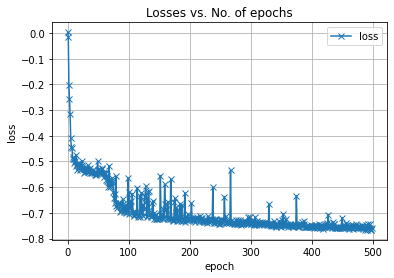

In [21]:
plot_history(ae.training_routine(range(start,500),train_loader,val_loader,"checkpoints/"))

## Testing

In [19]:
import os
import numpy as np
import torch
from CA import AE
from utils import testing, display_image, display_difference, process_results, display_plots
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
ckpt="checkpoints/498_best.pth"

ckpt=torch.load(ckpt)
ae=AE().to(device)
ae.load_state_dict(ckpt["AE"])
ae.optimizer.load_state_dict(ckpt["AE_optim"])
ae.eval();

In [23]:
patient_info=np.load("preprocessed/patient_info.npy",allow_pickle=True).item()
spacings=[patient_info[id]["spacing"] for id in range(1,101)]
current_spacing=np.percentile(np.vstack(spacings),50,0)

In [51]:
if not os.path.exists("postprocessed/measures"):
  os.makedirs("postprocessed/measures")
for model in sorted(test_loaders.keys()):
  if not os.path.exists("postprocessed/predictions/{}".format(model)):
    os.makedirs("postprocessed/predictions/{}".format(model))
  results=testing(ae,test_loaders[model],patient_info,"data/predictions/{}".format(model),"postprocessed/predictions/{}".format(model),current_spacing)
  np.save("postprocessed/measures/{}_AE.npy".format(model),results)

### Single patient

In [26]:
model="Bai"
patient_id=102
phase="ED"

prediction=nib.load("data/predictions/{}/patient{:03d}_{}.nii.gz".format(model,patient_id,phase)).get_fdata().transpose(2,1,0)
reconstruction=nib.load("postprocessed/predictions/{}/patient{:03d}_{}.nii.gz".format(model,patient_id,phase)).get_fdata().transpose(2,1,0)

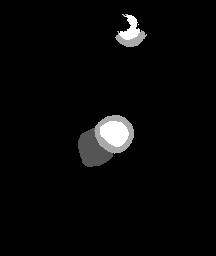

In [39]:
from utils import display_image, display_difference
display_image(prediction[2])

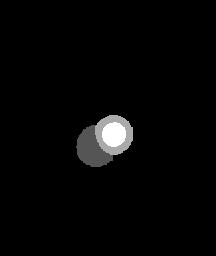

In [40]:
display_image(reconstruction[2])

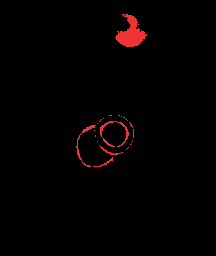

In [31]:
display_difference(prediction[2],reconstruction[2])

### Plots

In [52]:
models=["Bai","Baumgartner","Grinias","Isensee","Khened","Yang"]
plots=process_results(models,"data/measures/","postprocessed/measures/")

Anomalies (DSC=0/HD=nan): 16
Spotted by CA: 15
False Positive by CA: 0
Total discarded from the next plots: 16


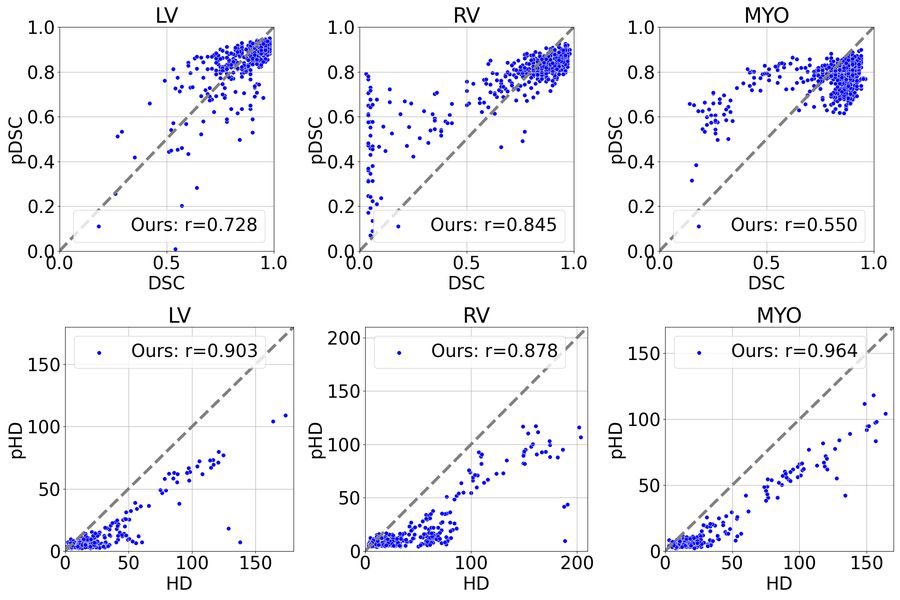

In [53]:
display_plots(plots)